<a href="https://colab.research.google.com/github/ferdevpy/kagglecompetitions/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Importando dados e bibliotecas


Aquisição de dados com API Kaggle

In [ ]:
from google.colab import files
up=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Importando Bibliotecas
! pip install kaggle
import kaggle
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp 
import IPython
from IPython import display 
import sklearn 
import random
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! kaggle competitions download -c digit-recognizer

  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 70.1MB/s]
 55% 5.00M/9.16M [00:00<00:00, 29.2MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.8MB/s]
 82% 5.00M/6.09M [00:00<00:00, 32.8MB/s]
100% 6.09M/6.09M [00:00<00:00, 29.6MB/s]


In [ ]:
import os
print(os.listdir("./"))

['.config', 'kaggle.json', 'train.csv.zip', 'test.csv', 'test.csv.zip', '.ipynb_checkpoints', 'sample_submission.csv', 'train.csv', 'sample_data']


In [ ]:
train=pd.read_csv("./train.csv.zip")
test=pd.read_csv("./test.csv.zip")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#2. Preparando dados

In [ ]:
#Retirando o target do dataset
target=train['label']
train=train.drop(columns='label')

In [ ]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB


In [ ]:
#Normalizando os dados para a escala de cinza
train=train/255.0
test=test/255.0

In [ ]:
# Modelando os dados para 28x28x1, pois as imagens estão no formato de vetor de 1D com 784 valores
train_images=train.values.reshape(len(train),28,28,1)
test_images=test.values.reshape(len(test),28,28,1)

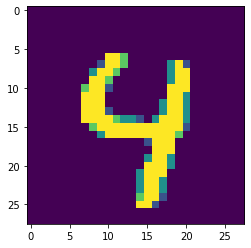

In [ ]:
#Visualizando uma amostra
plt.imshow(train_images[78][:,:,0])

#3. Modelo preditivo

In [ ]:
#Carregando bibliotecas para modelo preditivo
import tensorflow as tf
from tensorflow import keras

In [ ]:
def build_model(hp):
    model=keras.Sequential([
        keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter',min_value=32,max_value=128,step=16), #escolherá um valor do range
        kernel_size=hp.Choice('conv_1_kernel',values=[3,5,7]),    #escolherá apenas os melhores valores
        activation='relu',input_shape=(28,28,1)
        ),
        keras.layers.Conv2D(
            filters=hp.Int('conv_2_filter',min_value=32,max_value=128,step=16),
            kernel_size=hp.Choice('conv_2_kernel',values=[3,5,7]),
            activation='relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('dense_1_units',min_value=32,max_value=128,step=16),
            activation='relu'
            ),
        keras.layers.Dense(10,activation='softmax')
        ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

###Melhoria por hiperparametro

In [ ]:
! pip install keras-tuner
from kerastuner import RandomSearch
from kerastuner import HyperParameters

In [ ]:
'''
O RandomSearch encontra um valor suficientemente próximo do valor ideal dos hiperparametros em menos iterações
'''
tuner_search=RandomSearch(build_model,max_trials=5,objective='val_accuracy')

In [ ]:
#Precisão do número de tentativas e hiperparametros usados para cada tentativa
tuner_search.search(train_images,target,epochs=3,validation_split=0.1,verbose=2)

Trial 5 Complete [00h 04m 22s]
val_accuracy: 0.9842857122421265

Best val_accuracy So Far: 0.988095223903656
Total elapsed time: 00h 48m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
#Escolhendo apenas os melhores modelos
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 48)        76848     
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 48)                921648    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
Total params: 1,000,650
Trainable params: 1,000,650
Non-trainable params: 0
_________________________________________________________________


###Testando modelo

In [ ]:
#Treinando o modelo
model.fit(train_images,target,epochs=8,initial_epoch=3,validation_split=0.1,verbose=1)


Epoch 4/8
1182/1182 [==============================] - 239s 202ms/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.0493 - val_accuracy: 0.9855
Epoch 5/8
1182/1182 [==============================] - 240s 203ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0524 - val_accuracy: 0.9857
Epoch 6/8
1182/1182 [==============================] - 237s 200ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0470 - val_accuracy: 0.9871
Epoch 7/8
1182/1182 [==============================] - 239s 202ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.0464 - val_accuracy: 0.9888
Epoch 8/8
1182/1182 [==============================] - 239s 202ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0410 - val_accuracy: 0.9902


In [ ]:
#Preparando predições
#coluna ImageId
test_pred=pd.DataFrame(model.predict(test_images,batch_size=200))
test_pred=pd.DataFrame(test_pred.idxmax(axis=1))
test_pred.index.name='ImageId'

#coluna label
test_pred=test_pred.rename(columns={0:'label'}).reset_index()
test_pred['ImageId']=test_pred['ImageId']+1
test_pred.head()

,ImageId,label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


#4. Submission

In [ ]:
test_pred.to_csv('submission.csv',index=False)